# Ejemplo de extracción de características mediante banco de filtros
*Ignacio Díaz Blanco, 2019. Universidad de Oviedo*

### Introducción
En este ejemplo se muestra cómo realizar una extracción de características mediante bancos de filtros usando Python. El ejemplo toma datos (reales) de un motor de CC de 6000kW durante laminación, con una duración de unos 40 segundos y tomados a una frecuencia de muestreo de 5000 Hz. Dado que el equipo utiliza equipos de electrónica potencia, ciertos armónicos de alta frecuencia (300 Hz, 600 Hz) revelan determinadas condiciones del equipo (consumo de potencia para dar par, regeneración, etc.).

### Condiciones en las que está realizado el ejemplo

* Los datos están disponibles en formato `*mat` de Matlab, muestreados a 5000 Hz (esto normalmente se conoce)
* Utilizaremos la función `loadmat()` para importarlos

* Comparamos los métodos 
    1. agregación por ventanas de energías en bandas de frecuencias (tamaño 1000 muestras, desplazadas 100 muestras)
    2. banco de filtros


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.matlab import loadmat
from __future__ import division

# directiva iPython para que las figuras aparezcan en línea
%matplotlib inline

In [2]:
# Cargamos los datos, disponibles en formato Matlab (*.mat)
datos = loadmat('../../datos/datosmotorlaminacion.mat')

# La frecuencia de muestreo son 5000 Hz (este dato normalmente lo tienen que dar)
fm = 5000
tm = 1/fm

In [3]:
# Extraemos los datos y metadatos de la estructura importada
p = datos['p']      # En la key "p" tenemos el array con los datos 
Q = p.shape[1]      # tamaño del array (número de muestras)
t = np.arange(Q)*tm    # vector de instantes (cada muestra, avanza tm segundos)
etiq = ['$I_a$', '$V_a$', '$I_f$', '$w$']    # nombres de las variables
unit = ['A','V','A','rpm']

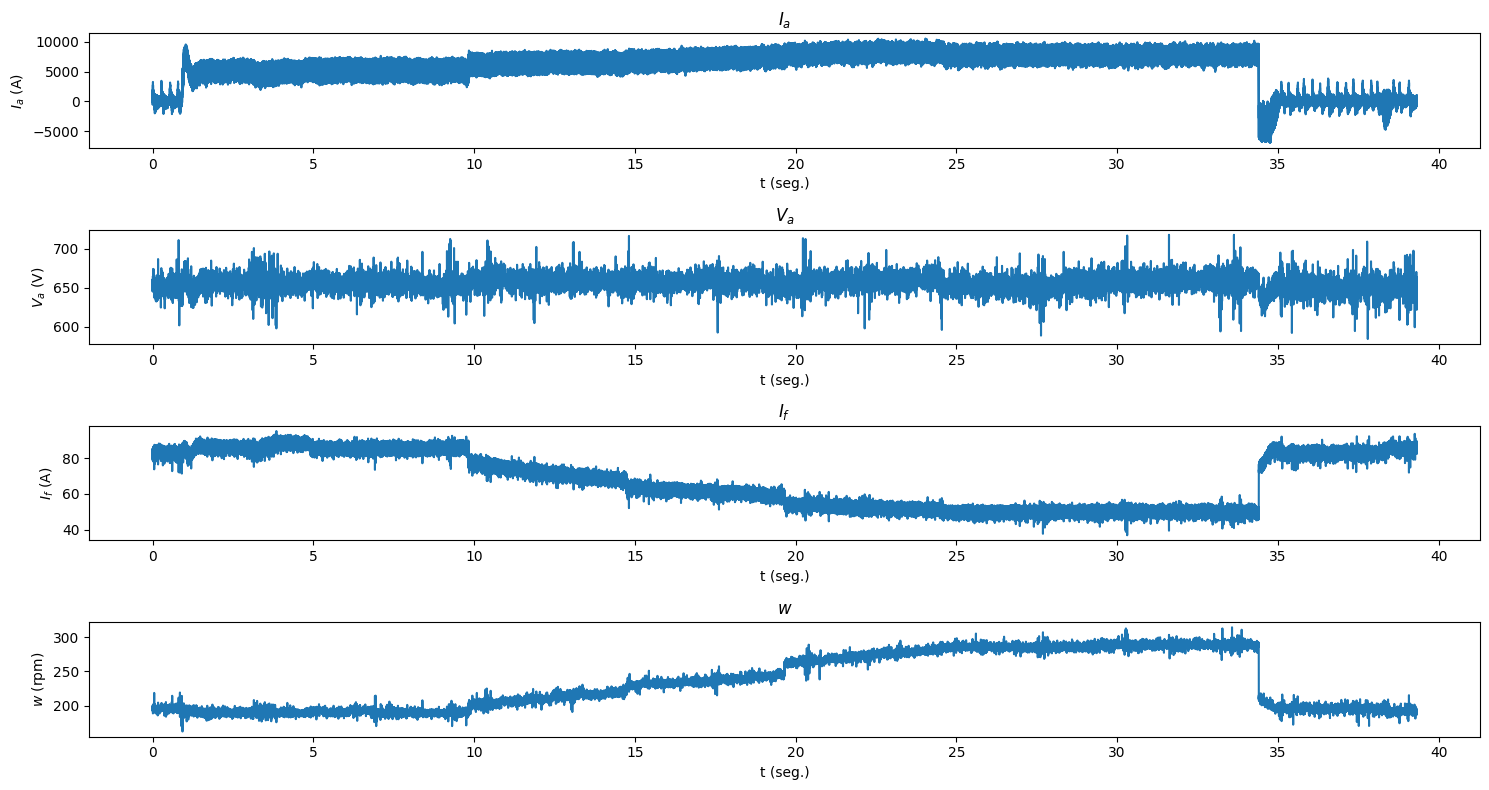

In [4]:
plt.figure(1,figsize=(15,8))
for k in range(4):
    plt.subplot(4,1,k+1)
    plt.plot(t,p[k,:])
    plt.title(etiq[k])
    plt.ylabel(etiq[k]+" ("+unit[k]+")")
    plt.xlabel("t (seg.)")
plt.tight_layout()

## Extracción de características mediante agregación de armónicos por ventanas

In [5]:
# Parámeetros de enventanado (criterios de agrupamiento de los datos)
N = 1000     # tamaño de la ventana (esto lo elegimos nosotros)
S = 100      # definimos el "salto" entre ventana y ventana 


# elegimos la primera variable (primera fila), que es I_a
Ia = p[0,:]   

# valores nominales de las variables del proceso
Ia_nom = 9000
Va_nom = 700
If_nom = 150
w_nom  = 150

# inicializamos la matriz con las características (lista vacía)
F = []

# Recorremos los datos con un bucle for
# utilizamos la función xrange(inicio, final, salto)
for k in range(N,Q,S):
    v = Ia[k-N:k]/Ia_nom           # definimos la ventana actual con N elementos (p.u. respecto valor nominal)
    V  = np.abs(np.fft.fft(v))               # calculamos la fft de la ventana
    f = np.arange(0,fm,fm/N)          # calculamos las frecuencias de cada armónico
    idx1 = np.where((f>280)&(f<320))   # generamos un vector de índices de los elementos que están entre 280 y 320 Hz
    idx2 = np.where((f>580)&(f<620))   # generamos un vector de índices de los elementos que están entre 580 y 620 Hz

    
    # La función append pemite añadir un elemento a una lista dada
    # aquí añadimos en cada iteración una lista con varias características
    # Para las frecuenciales obtenemos valores eficaces (RMS) en bandas de frecuencia
    # Nota 1: el factor 2 es para incluir las "frecuencias negativas"
    # Nota 2: el factor 2 no debe aplicarse para la frecuencia continua ni para la de Nyquist, 
    #         ya que ambas incorporan en un solo armónico la positiva y la negativa)
    F.append(                     
        [
            np.mean(v),                        # valor medio de I_a por ventana (I_a agregada por ventanas) en p.u
            np.sqrt(sum(2*V[idx1]**2))/N,      # valor eficaz (RMS) de los armónicos entre 280 y 320 Hz
            np.sqrt(sum(2*V[idx2]**2))/N       # valor eficaz (RMS) de los armónicos entre 580 y 620 Hz
        ])

# etiquetas de las características que creamos
etiq_car = [
    '$I_a$ en p.u.',
    'valor RMS de $I_a$ en banda 280-320',
    'valor RMS de $I_a$ en banda 580-620'
]



In [6]:
np.array(F)

array([[ 0.02055455,  0.04387081,  0.03124613],
       [ 0.0058087 ,  0.04471633,  0.02914094],
       [-0.00649652,  0.04469368,  0.03041378],
       ...,
       [ 0.00724313,  0.05442881,  0.02782375],
       [-0.00664961,  0.05548216,  0.02960309],
       [-0.01243502,  0.05592944,  0.02810596]], shape=(1957, 3))

In [7]:


# tras el bucle for, F es una lista de listas
# para poder usar funciones de numpy y matplotlib la convertimos en un array
F  = np.array(F)
tF = np.arange(N,Q,S)*tm



In [8]:
# Nota (comprobación del teorema de Parseval)
# Energia en el dominio del tiempo
Energia_tot1 = sum(v**2);
# Energia en el dominio de la frecuencia (para la FFT tal y como se define en Matlab)
Energia_tot2 = sum(V**2)/N;

print ('Energía (dom. tiempo): \t %1.3f \nEnergía (dom. frec.): \t %1.3f'%(Energia_tot1,Energia_tot2))

# Nota (comprobación de igualdades de valores eficaces (rms)
# RMS en el dominio del tiempo
RMS_tot1 = np.sqrt(sum(v**2)/N);
# RMS en el dominio de la frecuencia
RMS_tot2 = np.sqrt(sum(V**2))/N;


print ('Valor RMS (dom. tiempo): \t %1.3f \nValor RMS (dom. frec.): \t %1.3f'%(RMS_tot1,RMS_tot2))





Energía (dom. tiempo): 	 4.701 
Energía (dom. frec.): 	 4.701
Valor RMS (dom. tiempo): 	 0.069 
Valor RMS (dom. frec.): 	 0.069


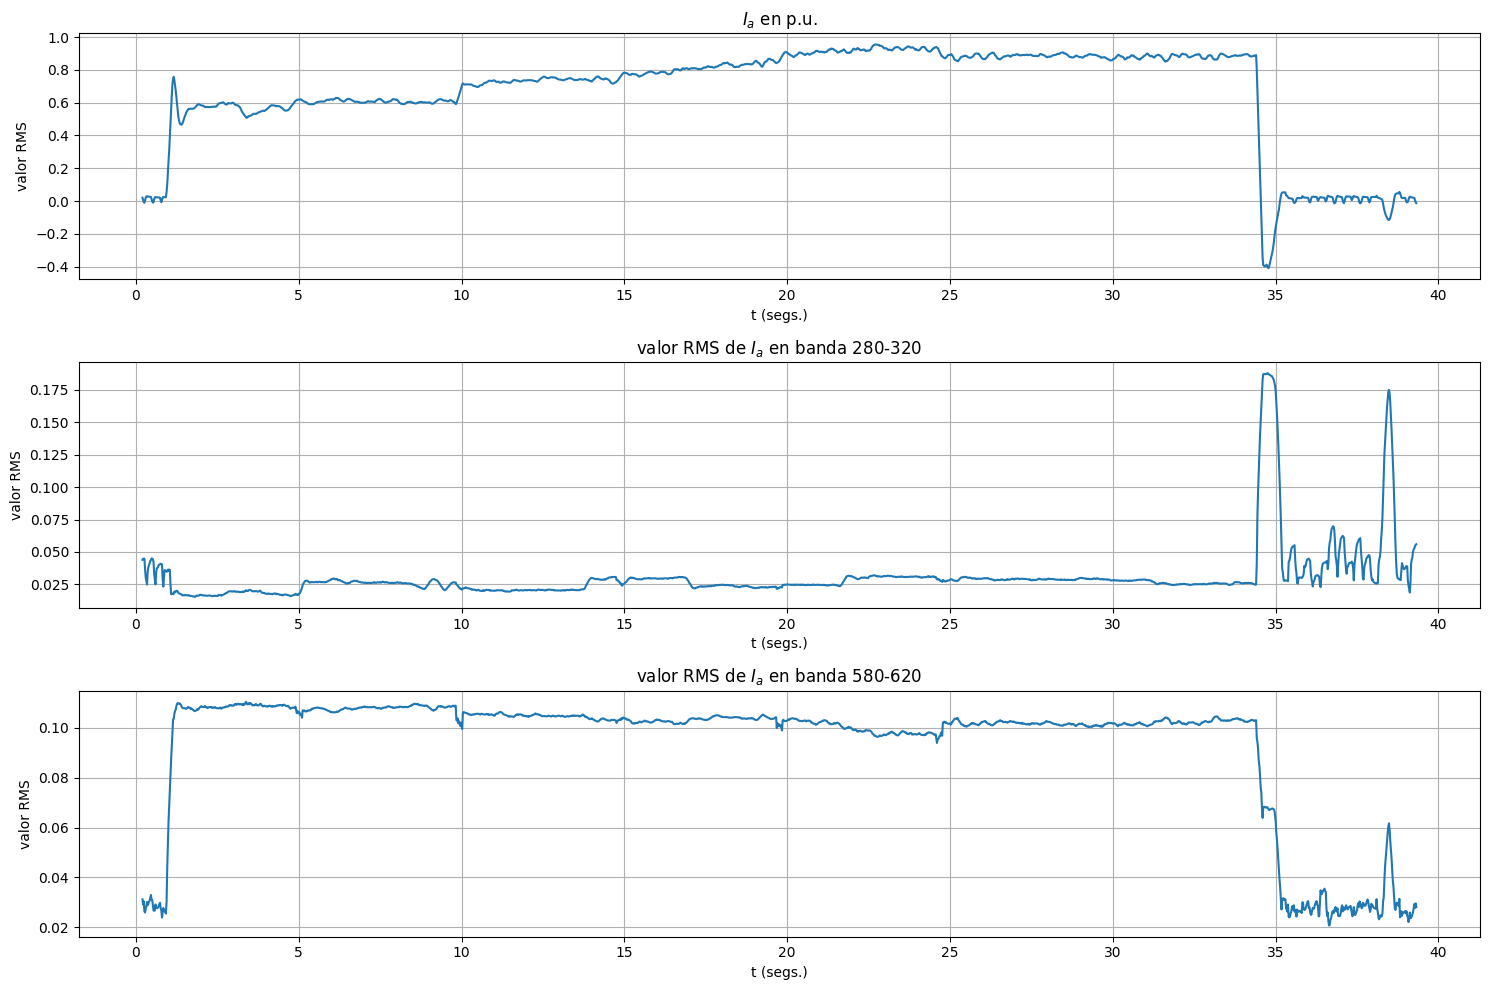

In [9]:
import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,10))

# la función subplot(4,1,i)
# divide la figura principal en (4 x 1) subplots y activa el i-esimo
# (cada nuevo comando "plot()" irá a dibujarse ahí)

nPlots = len(etiq_car)
for i,aux in enumerate(etiq_car):
    plt.subplot(nPlots,1,i+1);       # indicamos el subplot donde vamos a dibujar
    plt.plot(tF,F[:,i]);       # trazamos la gráfica temporal
    plt.title(etiq_car[i]);      # título del subplot
    plt.xlabel('t (segs.)')   # etiqueta de abscisas
    plt.ylabel('valor RMS')
    plt.grid(True);

# evitar solapamientos en las figuras
plt.tight_layout()



## Extracción de características mediante banco de filtros


In [10]:
import scipy.signal as sig

# filtro pasabanda (dejamos pasar 580-620 Hz)
bb = sig.firwin(51,np.array([580,620])/(fm/2),pass_zero=False)
ab = np.array([1])

# filtro pasabajos (segunda etapa, para obtener el RMS de la señal filtrada)
[bm,am] = sig.butter(4,0.001)

Ian    = Ia/Ia_nom
Iaf    = sig.lfilter(bb,1,Ian)
IafRMS = np.sqrt(sig.lfilter(bm,am,Iaf**2))


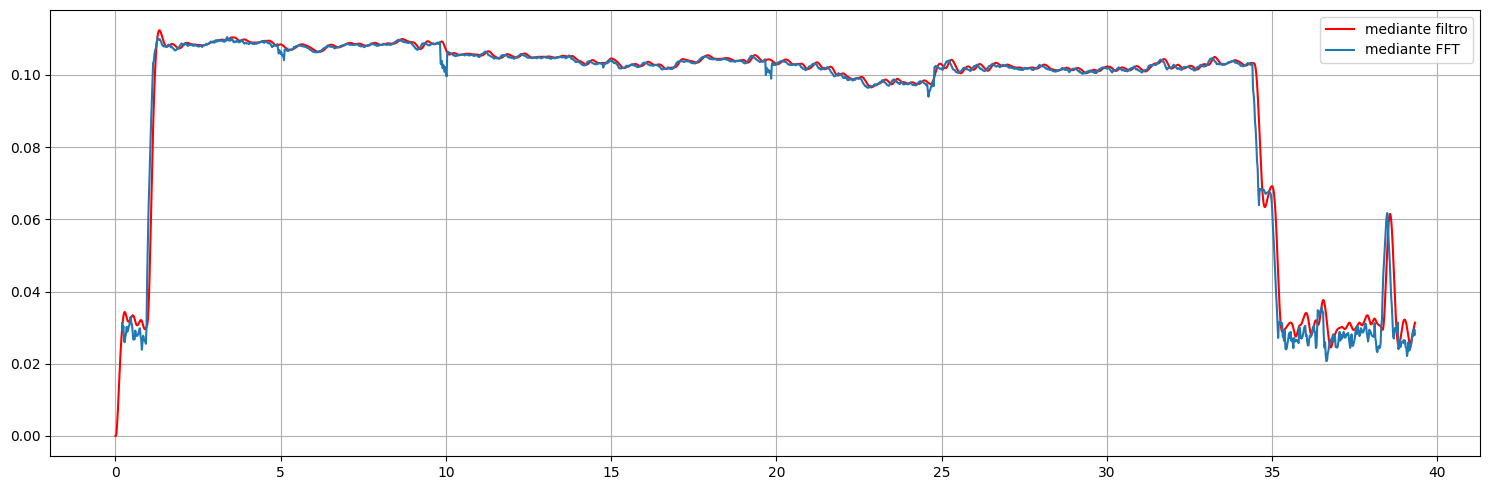

In [11]:
plt.figure(2,figsize=(15,5))

plt.plot(t,IafRMS,color='red')
plt.plot(tF,F[:,2])
plt.grid(True)
plt.tight_layout()
plt.legend(['mediante filtro','mediante FFT'])

## Respuesta en frecuencia de los filtros

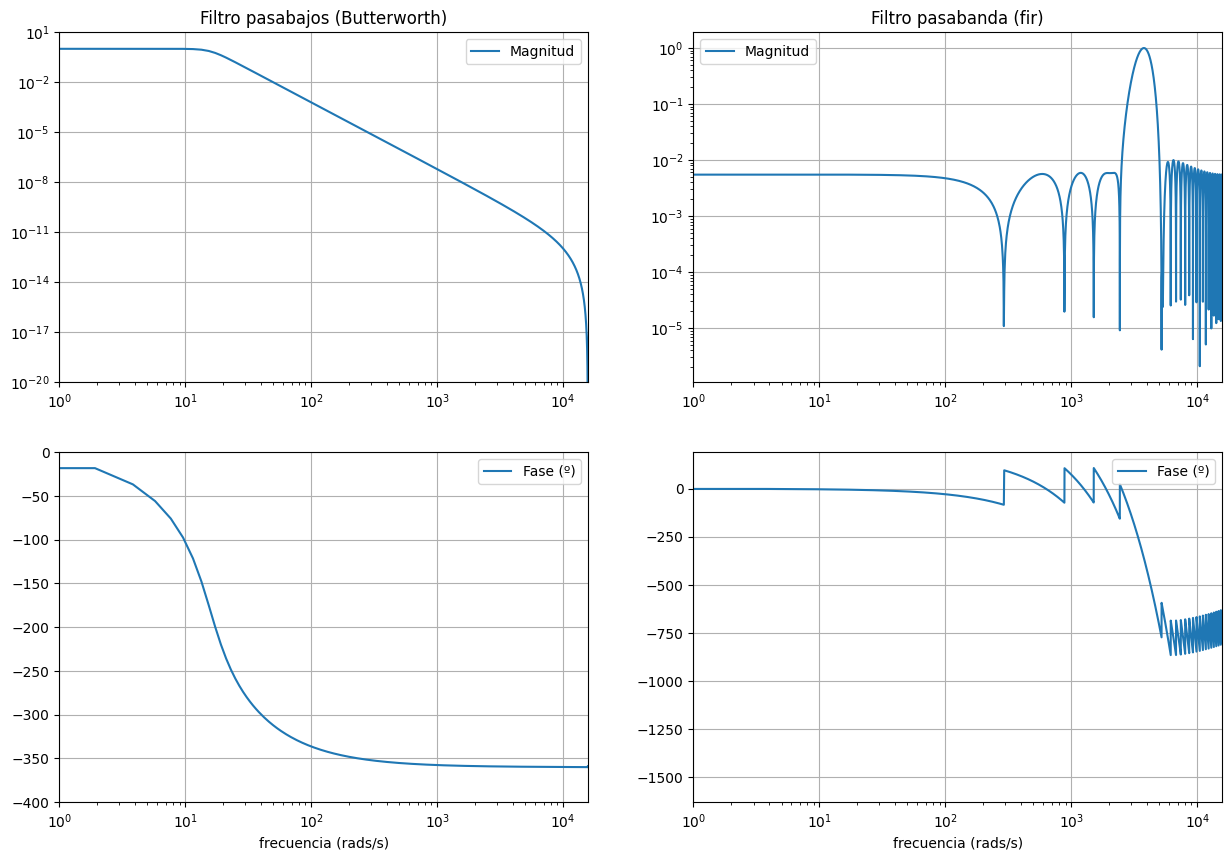

In [12]:
N = 16384
f = np.arange(0,fm,fm/N)


plt.figure(3,figsize=(15,10))

# Filtro pasabajos (Butterworth)
# magnitud
plt.subplot(2,2,1)
plt.title('Filtro pasabajos (Butterworth)')
plt.loglog(f*2*np.pi,abs(np.fft.fft(bm,N)/np.fft.fft(am,N)))
plt.axis(xmin=1,xmax=2500*2*np.pi,ymin=1e-20,ymax=10)
plt.grid(True)
plt.legend(['Magnitud'])

# fase
plt.subplot(2,2,3)
plt.semilogx(f*2*np.pi,np.unwrap(np.angle(np.fft.fft(bm,N)/np.fft.fft(am,N)))*180/np.pi)
plt.axis(xmin=1,xmax=2500*2*np.pi,ymin=-400,ymax=0)
plt.grid(True)
plt.xlabel('frecuencia (rads/s)')
plt.legend(['Fase (º)'])
# Filtro pasabanda (fir)
# magnitud
plt.subplot(2,2,2)
plt.title('Filtro pasabanda (fir)')
plt.loglog(f*2*np.pi,abs(np.fft.fft(bb,N)/np.fft.fft(ab,N)))
plt.axis(xmin=1,xmax=2500*2*np.pi)
plt.grid(True)
plt.legend(['Magnitud'])

# fase
plt.subplot(2,2,4)
plt.semilogx(f*2*np.pi,np.unwrap(np.angle(np.fft.fft(bb,N)/np.fft.fft(ab,N)))*180/np.pi)
plt.axis(xmin=1,xmax=2500*2*np.pi)
plt.xlabel('frecuencia (rads/s)')
plt.grid(True)
plt.legend(['Fase (º)']);

In [13]:
%%html
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">"Ejemplo de extracción de características mediante banco de filtros
"</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.